In [43]:
# import all needed modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import wordcloud
import pickle

### READ AND CLEAN DATA

In [2]:
# read all data from csvs into dfs
# data is from UCI's dataset repository
df_psy = pd.read_csv("YouTube-Spam-Collection-v1/Youtube01-Psy.csv")
df_katy_perry = pd.read_csv("YouTube-Spam-Collection-v1/Youtube02-KatyPerry.csv")
df_lmfao = pd.read_csv("YouTube-Spam-Collection-v1/Youtube03-LMFAO.csv")
df_eminem = pd.read_csv("YouTube-Spam-Collection-v1/Youtube04-Eminem.csv")
df_shakira = pd.read_csv("YouTube-Spam-Collection-v1/Youtube05-Shakira.csv")

In [60]:
# merge all dfs into one
df_comments = pd.concat([df_psy, df_katy_perry, df_lmfao, df_eminem, df_shakira], ignore_index = True)

# clean data
df_comments.drop(['COMMENT_ID', 'AUTHOR', 'DATE'], axis = 1, inplace = True)

In [4]:
#rename class to spam for convenience
df_comments.rename(columns = {'CLASS':'SPAM'}, inplace = True)

# check relatively even numbers of spam and not spam
# 1 = spam, 0 = not spam
df_comments['SPAM'].value_counts()

1    1005
0     951
Name: SPAM, dtype: int64

### WORDCLOUD CREATION

In [5]:
# function to create a wordcloud to see what the most common words of each category are
def create_wordcloud(df, title):
    text = ' '.join(df['CONTENT'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

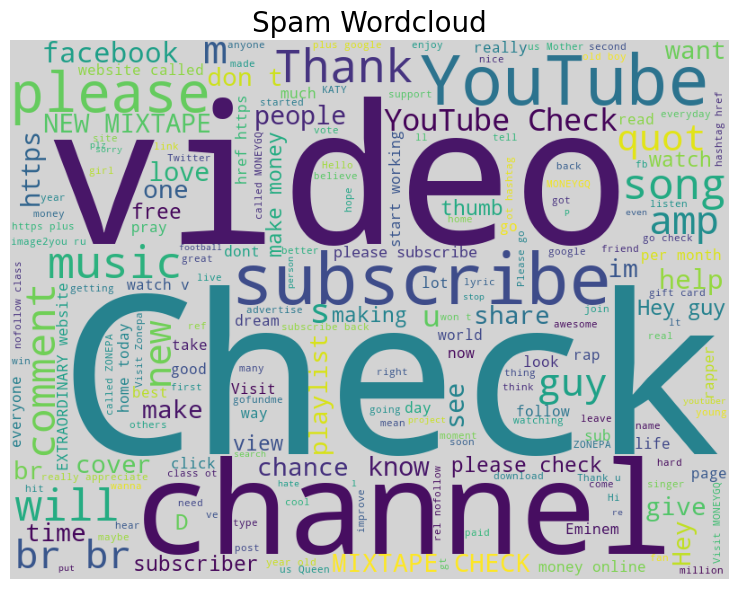

In [6]:
# spam wordcloud
create_wordcloud(df_comments[df_comments['SPAM'] == 1], 'Spam Wordcloud')

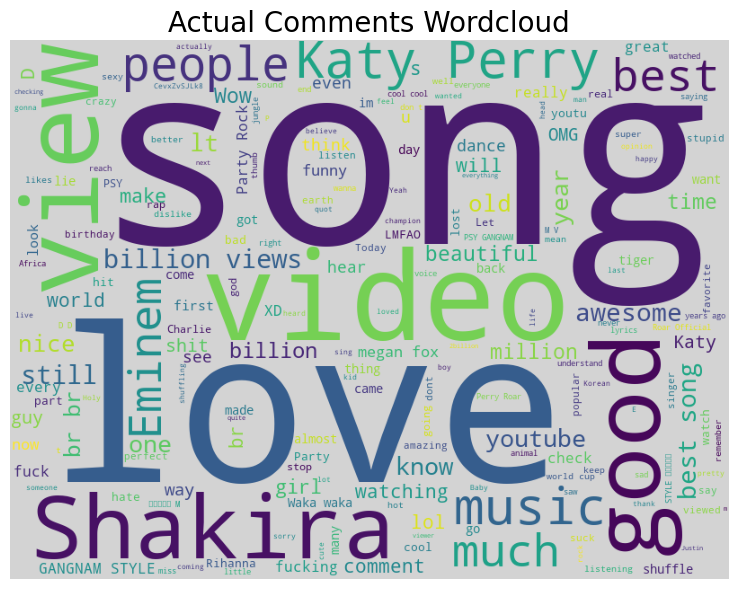

In [7]:
# actual comments wordcloud
create_wordcloud(df_comments[df_comments['SPAM'] == 0], 'Actual Comments Wordcloud')

### DEEP LEARNING PREP


In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

In [9]:
# values of contents column of df
content_vals = df_comments['CONTENT'].values

# values of spam flag column of df
spam_vals = df_comments['SPAM'].values

In [10]:
# split into train and test better accuracy
content_train, content_test, spam_train, spam_test = train_test_split(content_vals, spam_vals, test_size = 0.2, random_state = 42)

In [11]:
# tokenizer to help with vectorization of text
tokenizer = Tokenizer()

# train tokenizer to turn text into lists of numbers that are representative of the test
tokenizer.fit_on_texts(content_train)

# encode text into integers based on training
encoded_train = tokenizer.texts_to_sequences(content_train)
encoded_test = tokenizer.texts_to_sequences(content_test)

In [12]:
# make all text the same length of 10 at most
text_size = 10
padded_train = pad_sequences(encoded_train, maxlen = text_size, padding = 'post')
padded_test = pad_sequences(encoded_test, maxlen = text_size, padding = 'post')

### DEEP LEARNING

In [13]:
# get number of words
num_words = len(tokenizer.word_index) + 1

In [14]:
# make deep learning model
model = Sequential()

# embed to make large inputs easier to process
model.add(Embedding(num_words, 32, input_length = text_size))

# define model further:
# flatten: turns into 1D array to help with further dense layers
# dense: specifies number of neurons to add complexity to the deep learning layer
# dropout: drops fraction of the neurons to prevent overfitting
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

2023-02-19 18:43:52.887988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# set early stopping when the model is not improving anymore
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model with data and number of epochs
model.fit(x = padded_train, y = spam_train, epochs = 50, validation_data = (padded_test, spam_test),
          verbose = 1, callbacks=[early_stop])

Epoch 1/50
49/49 [==============================] - 1s 4ms/step - loss: 0.4486 - accuracy: 0.7653 - val_loss: 0.2623 - val_accuracy: 0.8903
Epoch 2/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1600 - accuracy: 0.9457 - val_loss: 0.2630 - val_accuracy: 0.9082
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0446 - accuracy: 0.9859 - val_loss: 0.3076 - val_accuracy: 0.9184
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9942 - val_loss: 0.3340 - val_accuracy: 0.8980
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9955 - val_loss: 0.3251 - val_accuracy: 0.9082
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.4305 - val_accuracy: 0.9235
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 8.0794e-04 - accuracy: 0.9994 - val_loss: 0.5458 - val_accuracy: 0.9133
Epoch 8/50
49/49

In [16]:
# save the model
model.save("youtube_spam_model")

INFO:tensorflow:Assets written to: youtube_spam_model/assets


In [25]:
# save tokenizer
with open('youtube_spam_model/tokenizer.pkl', 'wb') as output:
   pickle.dump(tokenizer, output, pickle.HIGHEST_PROTOCOL)

### MAKE PREDICTIONS USING MODEL AND CHECK RESULTS

In [17]:
# import functions to produce measurements of results
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [19]:
# load saved model
spam_model = tf.keras.models.load_model("youtube_spam_model")

In [20]:
# use the model to predict the test values
spam_preds = (spam_model.predict(padded_test) > 0.5).astype("int32")

13/13 [==============================] - 0s 914us/step


In [68]:
# create a list from tuple of tuples
preds = [pred_value for each_pred in spam_preds for pred_value in each_pred]

In [88]:
# save predictions df
pred_df = pd.DataFrame({'CONTENT' : content_test, 'SPAM' : preds}, columns = ['CONTENT', 'SPAM'])
pred_df.to_csv('spam_preds.csv', index = False)

In [87]:
# show the accuracy score of the model
print("Accuracy: " + str(accuracy_score(spam_test, spam_preds)))

Accuracy: 0.9132653061224489


In [22]:
# create a classification report to check model performance
print(classification_report(spam_test, spam_preds))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       176
           1       0.91      0.93      0.92       216

    accuracy                           0.91       392
   macro avg       0.91      0.91      0.91       392
weighted avg       0.91      0.91      0.91       392



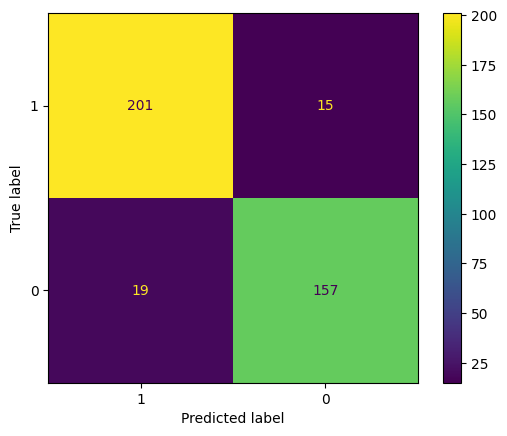

In [23]:
# create and display confusion matrix for results
conf_matrix = confusion_matrix(spam_test, spam_preds, labels = df_comments['SPAM'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix,
                              display_labels = df_comments['SPAM'].unique())
disp.plot()

In [85]:
 # add a new column
df_comments['PREDICTED'] = 0

# make new list such that content_test can be useda gain
test_comments = list(content_test)

# mark comments as predicted or not (used to calculate accuracy later)
for i in range(len(df_comments)):
    if df_comments['CONTENT'][i] in test_comments:
        test_comments.remove(df_comments['CONTENT'][i])
        df_comments['PREDICTED'][i] = True
    else:
        df_comments['PREDICTED'][i] = False
    
# save comments df       
df_comments.to_csv('spam_comments.csv', index = False)